In [188]:
from pathlib import Path
from analytics.app.data.load import list_pipelines
from analytics.app.data.transform import dfs_models_and_evals
from analytics.app.data.transform import patch_yearbook_time
from analytics.app.data.transform import logs_dataframe
from analytics.app.data.transform import df_aggregate_eval_metric
from analytics.app.data.transform import logs_dataframe_agg_by_stage
from modyn.supervisor.internal.grpc.enums import PipelineStage


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from analytics.plotting.common.common import SAVE_PLOT

%load_ext autoreload
%autoreload 2

TIMING_STAGES = { "DONE", "EVALUATE", "EVALUATE_TRIGGER_POLICY", "INFORM_SELECTOR_ABOUT_TRIGGER", "INFORM_SELECTOR_REMAINING_DATA", "INIT_CLUSTER_CONNECTION", "STORE_TRAINED_MODEL", "TRAIN", "TRAINING_COMPLETED" } 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
# INPUTS
plot_yearbook = False
output_dir = Path(
    "/Users/mboether/phd/dynamic-data/dynamic_datasets_dsl/analytics/plotting/sigmod"
)

if plot_yearbook:
    pipelines_dir = Path(
        "/Users/mboether/phd/dynamic-data/sigmod-data/yearbook/data_selection_50%/logs_agg_patch"
    )
    composite_model_variant = "currently_active_model"  # currently_trained_model
    patch_yearbook = True
    dataset_id = "yearbook_test"
    eval_handler = "slidingmatrix"
    metric = "Accuracy"
else:
    pipelines_dir = Path(
        "/Users/mboether/phd/dynamic-data/sigmod-data/cglm-landmark/data_selection/logs_agg_patch_currently_trained"
    )
    composite_model_variant = "currently_trained_model"
    patch_yearbook = False
    dataset_id = "cglm_landmark_min25-test"
    eval_handler = "exactmatrix"
    metric = "Top-5-Accuracy"

assert pipelines_dir.exists()
assert output_dir.exists()

In [208]:
def map_pipeline_names(pipeline_ref: str) -> str:
    stripped = re.sub(
            "_nosched.*",
            "",
            (
                pipeline_ref\
                .removeprefix("yearbook_yearbooknet_")\
                .removeprefix("cglm_")
            ),
    )
    return {
        "full": "Full",
        "rs2wo": "RS2 (w/o)",
        "grad_bts": "DLIS",
        "margin_bts": "Margin",
        "lc_bts": "Least conf.",
        "entropy_bts": "Entropy",
        "rs2w": "RS2",
        "classb": "Class-Bal.",
        "uniform": "Uniform",
        "loss_bts": "Loss",
    }.get(stripped, stripped) + "  "

In [209]:
pipelines = list_pipelines(pipelines_dir)
# rename
pipelines = {
    int(k): (
        map_pipeline_names(v[0]), v[1]
    ) 
    for k, v in pipelines.items()
    #if (v[0].endswith("_r250") or "full" in v[0]) # for inspecting 25% selection
    #if (v[0].endswith("_r125") or "full" in v[0]) # for inspecting 12.5% selection
    if not (v[0].endswith("_r125") or v[0].endswith("_r250"))
}
max_pipeline_id = max(pipelines.keys())
pipelines

{2: ('Uniform  ', PosixPath('pipeline_2')),
 11: ('Loss  ', PosixPath('pipeline_11')),
 16: ('Margin  ', PosixPath('pipeline_16')),
 17: ('Least conf.  ', PosixPath('pipeline_17')),
 18: ('DLIS  ', PosixPath('pipeline_18')),
 19: ('RS2 (w/o)  ', PosixPath('pipeline_19')),
 24: ('Full  ', PosixPath('pipeline_24')),
 130: ('Entropy  ', PosixPath('pipeline_130')),
 135: ('RS2  ', PosixPath('pipeline_135'))}

In [210]:
from analytics.app.data.load import load_pipeline_logs


pipeline_logs = {
    p_id: load_pipeline_logs(p_id, pipelines_dir)
    for (p_id, (_, p_path)) in pipelines.items()
    if p_id != 21 # exclude rho loss
}
pipeline_ids = list(pipeline_logs.keys())

# Wrangle data

In [211]:
list_df_eval_single: list[pd.DataFrame] = []
list_of_timing_dfs: list[pd.DataFrame] = []

for pipeline_id in pipeline_ids:
    df_all = logs_dataframe(pipeline_logs[pipeline_id], pipelines[pipeline_id][0])
    list_of_timing_dfs.append(df_all[df_all["id"].isin(TIMING_STAGES)].groupby(["pipeline_ref"]).agg(cost=("duration", "sum")).reset_index())

    _, _, df_eval_single = dfs_models_and_evals(
        pipeline_logs[pipeline_id], df_all["sample_time"].max(), pipelines[pipeline_id][0]
    )
    list_df_eval_single.append(df_eval_single)

df_adjusted = pd.concat(list_df_eval_single)
df_timing = pd.concat(list_of_timing_dfs)
df_adjusted


,trigger_id,training_id,id_model,currently_active_model,currently_trained_model,eval_handler,dataset_id,interval_start,interval_end,dataset_size,metric,value,interval_center,training_idx,model_idx,pipeline_ref
0,0,0,1,True,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Accuracy,0.000000,2004-07-01 12:00:00,1,1,Uniform
74,12,31,32,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-5-Accuracy,0.200000,2004-07-01 12:00:00,13,13,Uniform
73,12,31,32,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-2-Accuracy,0.066667,2004-07-01 12:00:00,13,13,Uniform
72,12,31,32,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Accuracy,0.000000,2004-07-01 12:00:00,13,13,Uniform
71,11,30,29,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,F1-micro,0.000000,2004-07-01 12:00:00,12,12,Uniform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,4,628,1710,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,F1-macro,0.000000,2020-06-27 12:00:00,5,5,RS2
1659,4,628,1710,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,F1-weighted,0.000000,2020-06-27 12:00:00,5,5,RS2
1658,4,628,1710,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,Top-5-Accuracy,0.000000,2020-06-27 12:00:00,5,5,RS2
1668,6,633,1715,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,Accuracy,0.000000,2020-06-27 12:00:00,7,7,RS2


In [212]:
df_timing

,pipeline_ref,cost
0,Uniform,5157.056968
0,Loss,9163.198012
0,Margin,8732.291605
0,Least conf.,8770.518974
0,DLIS,9182.099079
0,RS2 (w/o),13352.427479
0,Full,9175.483287
0,Entropy,9161.858395
0,RS2,13371.193851


In [213]:
df_adjusted = df_adjusted[
    (df_adjusted["dataset_id"] == dataset_id)
    & (df_adjusted["eval_handler"] == eval_handler)
    & (df_adjusted["metric"] == metric)
]

# in percent (0-100)
df_adjusted["value"] = df_adjusted["value"] * 100
df_adjusted

,trigger_id,training_id,id_model,currently_active_model,currently_trained_model,eval_handler,dataset_id,interval_start,interval_end,dataset_size,metric,value,interval_center,training_idx,model_idx,pipeline_ref
74,12,31,32,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-5-Accuracy,20.000000,2004-07-01 12:00:00,13,13,Uniform
68,11,30,29,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-5-Accuracy,0.000000,2004-07-01 12:00:00,12,12,Uniform
62,10,27,28,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-5-Accuracy,0.000000,2004-07-01 12:00:00,11,11,Uniform
56,9,25,25,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-5-Accuracy,6.666667,2004-07-01 12:00:00,10,10,Uniform
98,16,40,39,False,False,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-5-Accuracy,0.000000,2004-07-01 12:00:00,17,17,Uniform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0,622,1703,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,Top-5-Accuracy,0.000000,2020-06-27 12:00:00,1,1,RS2
1676,7,635,1718,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,Top-5-Accuracy,4.040404,2020-06-27 12:00:00,8,8,RS2
1670,6,633,1715,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,Top-5-Accuracy,3.030303,2020-06-27 12:00:00,7,7,RS2
1664,5,630,1713,False,False,exactmatrix,cglm_landmark_min25-test,2019-12-28,2020-12-27,33,Top-5-Accuracy,2.020202,2020-06-27 12:00:00,6,6,RS2


In [214]:
if patch_yearbook:
    for column in ["interval_start", "interval_center", "interval_end"]:
        patch_yearbook_time(df_adjusted, column)
    patch_yearbook_time(df_all, "sample_time")

In [215]:
df_adjusted = df_adjusted.sort_values(by=["interval_center"])

In [216]:
# Reduce to composite models
df_adjusted = df_adjusted[df_adjusted[composite_model_variant]]
df_adjusted[composite_model_variant].unique()

array([ True])

# Dump Data backup

# Create Plot

In [217]:
# reduce evaluation interval to interval where all policies have evaluations
min_active_eval_center_per_pipeline = df_adjusted[
    df_adjusted[composite_model_variant]
].groupby("pipeline_ref")["interval_center"].min()
maximum_min = min_active_eval_center_per_pipeline.max()
print(maximum_min, min_active_eval_center_per_pipeline)

df_adjusted = df_adjusted[
    df_adjusted["interval_center"] >= maximum_min
]
df_adjusted["interval_center"].unique() 

2004-07-01 12:00:00 pipeline_ref
DLIS            2004-07-01 12:00:00
Entropy         2004-07-01 12:00:00
Full            2004-07-01 12:00:00
Least conf.     2004-07-01 12:00:00
Loss            2004-07-01 12:00:00
Margin          2004-07-01 12:00:00
RS2             2004-07-01 12:00:00
RS2 (w/o)       2004-07-01 12:00:00
Uniform         2004-07-01 12:00:00
Name: interval_center, dtype: datetime64[ns]


<DatetimeArray>
['2004-07-01 12:00:00', '2005-07-01 12:00:00', '2006-07-01 12:00:00',
 '2007-07-01 12:00:00', '2008-06-30 12:00:00', '2009-06-30 12:00:00',
 '2010-06-30 12:00:00', '2011-06-30 12:00:00', '2012-06-29 12:00:00',
 '2013-06-29 12:00:00', '2014-06-29 12:00:00', '2015-06-29 12:00:00',
 '2016-06-28 12:00:00', '2017-06-28 12:00:00', '2018-06-28 12:00:00',
 '2019-06-28 12:00:00']
Length: 16, dtype: datetime64[ns]

In [218]:
df_adjusted["interval_center"] = df_adjusted["interval_center"].astype(str).str.split("-").str[0]


In [219]:
df_adjusted[df_adjusted["pipeline_ref"].str.contains("Full")]

,trigger_id,training_id,id_model,currently_active_model,currently_trained_model,eval_handler,dataset_id,interval_start,interval_end,dataset_size,metric,value,interval_center,training_idx,model_idx,pipeline_ref
8,1,169,372,False,True,exactmatrix,cglm_landmark_min25-test,2004-01-01,2004-12-31,5,Top-5-Accuracy,0.000000,2004,2,2,Full
116,2,170,374,False,True,exactmatrix,cglm_landmark_min25-test,2004-12-31,2005-12-31,154,Top-5-Accuracy,17.748918,2005,3,3,Full
224,3,172,378,False,True,exactmatrix,cglm_landmark_min25-test,2005-12-31,2006-12-31,346,Top-5-Accuracy,22.061657,2006,4,4,Full
332,4,177,382,False,True,exactmatrix,cglm_landmark_min25-test,2006-12-31,2007-12-31,671,Top-5-Accuracy,38.152012,2007,5,5,Full
440,5,180,384,False,True,exactmatrix,cglm_landmark_min25-test,2007-12-31,2008-12-30,772,Top-5-Accuracy,40.328152,2008,6,6,Full
548,6,183,389,False,True,exactmatrix,cglm_landmark_min25-test,2008-12-30,2009-12-30,1190,Top-5-Accuracy,50.056023,2009,7,7,Full
656,7,187,391,False,True,exactmatrix,cglm_landmark_min25-test,2009-12-30,2010-12-30,1505,Top-5-Accuracy,46.467331,2010,8,8,Full
764,8,189,395,False,True,exactmatrix,cglm_landmark_min25-test,2010-12-30,2011-12-30,2996,Top-5-Accuracy,46.228305,2011,9,9,Full
872,9,193,398,False,True,exactmatrix,cglm_landmark_min25-test,2011-12-30,2012-12-29,2310,Top-5-Accuracy,52.092354,2012,10,10,Full
980,10,197,403,False,True,exactmatrix,cglm_landmark_min25-test,2012-12-29,2013-12-29,4001,Top-5-Accuracy,55.977674,2013,11,11,Full


In [220]:
# Aggregate metrics to a scalar value per pipeline
mean_accuracies = df_aggregate_eval_metric(
    df_adjusted,
    group_by=["pipeline_ref", "metric"],
    in_col="value",
    out_col="metric_value",
    aggregate_func="mean",
)

timing_acc_df = mean_accuracies.merge(df_timing, on="pipeline_ref")
timing_acc_df


,pipeline_ref,metric,metric_value,cost
0,DLIS,Top-5-Accuracy,38.879207,9182.099079
1,Entropy,Top-5-Accuracy,38.433800,9161.858395
2,Full,Top-5-Accuracy,46.211882,9175.483287
3,Least conf.,Top-5-Accuracy,38.362238,8770.518974
4,Loss,Top-5-Accuracy,37.012070,9163.198012
5,Margin,Top-5-Accuracy,39.724448,8732.291605
6,RS2,Top-5-Accuracy,38.757797,13371.193851
7,RS2 (w/o),Top-5-Accuracy,38.846421,13352.427479
8,Uniform,Top-5-Accuracy,37.948819,5157.056968


In [221]:
mean_accuracies

,pipeline_ref,metric,metric_value
0,DLIS,Top-5-Accuracy,38.879207
1,Entropy,Top-5-Accuracy,38.433800
2,Full,Top-5-Accuracy,46.211882
3,Least conf.,Top-5-Accuracy,38.362238
4,Loss,Top-5-Accuracy,37.012070
5,Margin,Top-5-Accuracy,39.724448
6,RS2,Top-5-Accuracy,38.757797
7,RS2 (w/o),Top-5-Accuracy,38.846421
8,Uniform,Top-5-Accuracy,37.948819


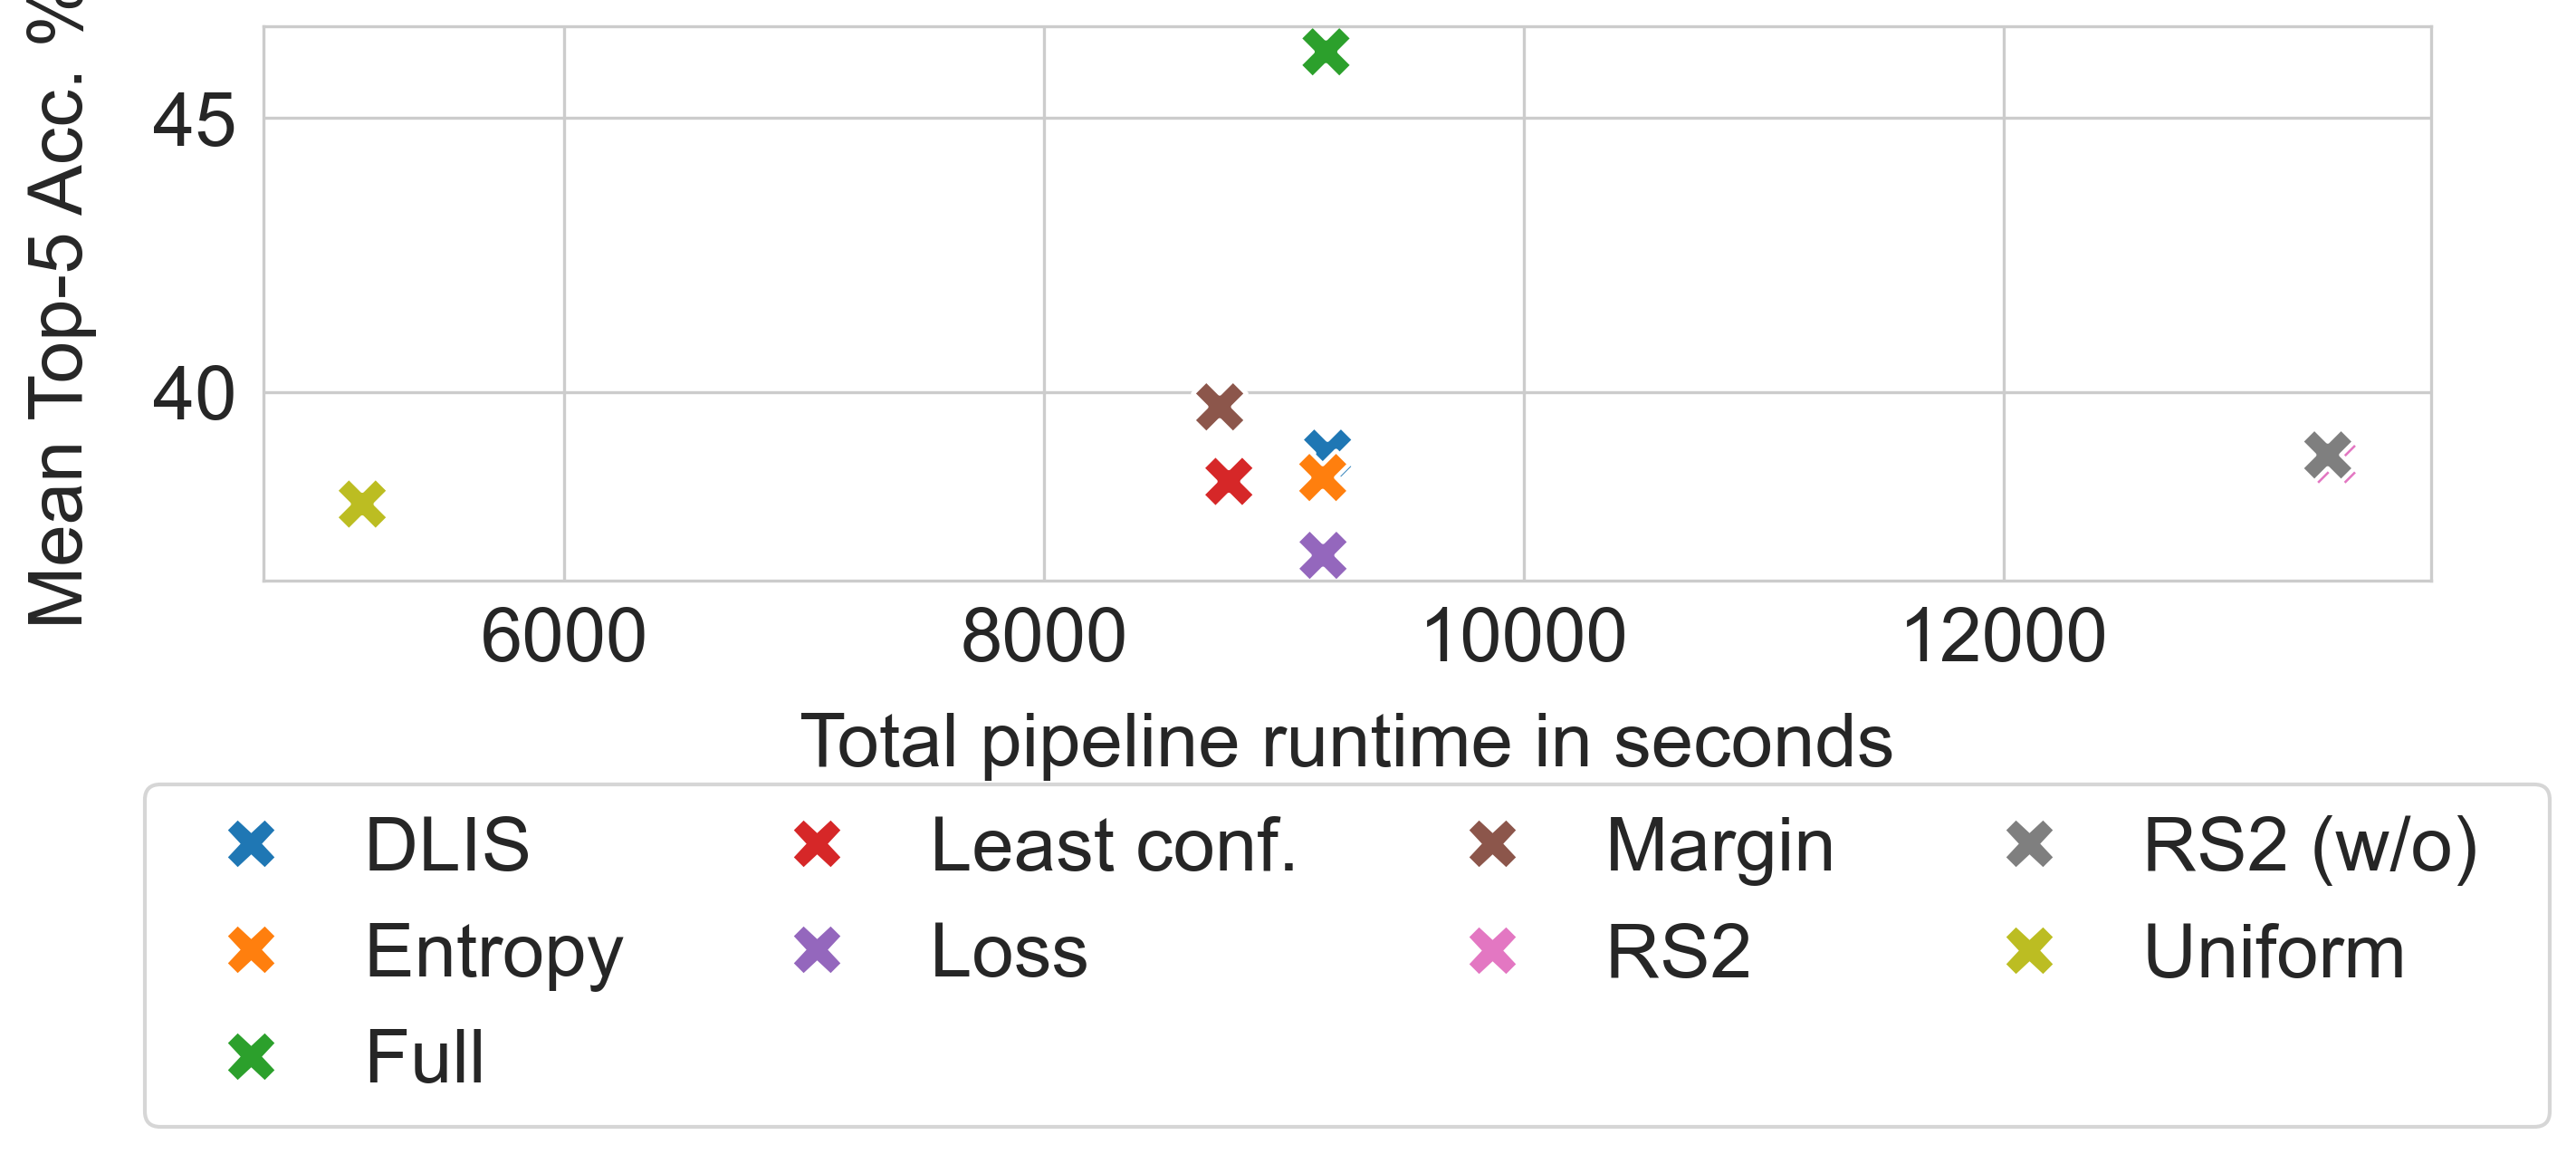

In [224]:

# Create the heatmap
from collections import defaultdict
from analytics.plotting.common.common import FIG_LEGEND, INIT_PLOT, RESIZE_TICKS


INIT_PLOT()
# sns.set_theme(style="ticks")
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("whitegrid")

FONTSIZE = 20
DOUBLE_FIG_WIDTH = 10
DOUBLE_FIG_HEIGHT = 3.5
DOUBLE_FIG_SIZE = (DOUBLE_FIG_WIDTH, 1.5 * DOUBLE_FIG_HEIGHT)

fig = plt.figure(
    edgecolor="black",
    frameon=True,
    figsize=DOUBLE_FIG_SIZE,
    dpi=300,
)

ax = sns.scatterplot(
    timing_acc_df,
    x="cost",
    y="metric_value",
    hue="pipeline_ref",
    s=200,
    marker='X',
    # annotations
    
)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, handletextpad=0.5, columnspacing=1.0)



# Adjust x-axis tick labels
plt.xlabel("Total pipeline runtime in seconds", labelpad=10)
#plt.xticks(
#    ticks=[x for x in range(0, 80+1, 20)],
#    labels=[x for x in range(0, 80+1, 20)],
#    rotation=0,
#    # ha='right'
#)

# Set y-axis ticks to be equally spaced
plt.ylabel("Mean Top-5 Acc. %", labelpad=15)
#plt.yticks(
#    ticks=[x for x in range(86, 95+1, 3)],
#    labels=[x for x in range(86, 95+1, 3)],
#    rotation=0,
#)

# Display the plot
plt.tight_layout()
plt.show()

# Save Plot as svg

In [225]:
for img_type in ["png", "svg"]:
    img_path = output_dir / f"revision_selection_timing.{img_type}"
    fig.savefig(img_path, bbox_inches="tight", transparent=True)